# What's cooking? - multiclass classification

Aim of this competition is to predict cuisine looking into ingredients used in recipe.

Full description below:

[What's Cooking?](https://www.kaggle.com/c/whats-cooking)

In [1]:
# libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings('ignore')

['test.json', 'train.json']


In [2]:
# loading data
train = pd.read_json("../input/train.json")
train.set_index("id", inplace=True)
test = pd.read_json("../input/test.json")
test.set_index("id", inplace=True)

## 1. Data understanding

In [3]:
print(train.info())
print("-" * 40)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39774 entries, 10259 to 2362
Data columns (total 2 columns):
cuisine        39774 non-null object
ingredients    39774 non-null object
dtypes: object(2)
memory usage: 932.2+ KB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9944 entries, 18009 to 1443
Data columns (total 1 columns):
ingredients    9944 non-null object
dtypes: object(1)
memory usage: 155.4+ KB
None


In [4]:
# sample of train data set
train.head()

,cuisine,ingredients
id,,
10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
22213,indian,"[water, vegetable oil, wheat, salt]"
13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [5]:
# list of unique ingredients
ingredients_list = []

for df in [train, test]:
    for ings in df["ingredients"]:
        for i in ings:
            if i not in ingredients_list:
                ingredients_list.append(i)

In [6]:
# number of unique ingredients
len(ingredients_list)

7137

## 2. Data Engineering

In [7]:
# new column with number of ingredients per recipe
for df in [train, test]:
    df["length"] = df["ingredients"].apply(len)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

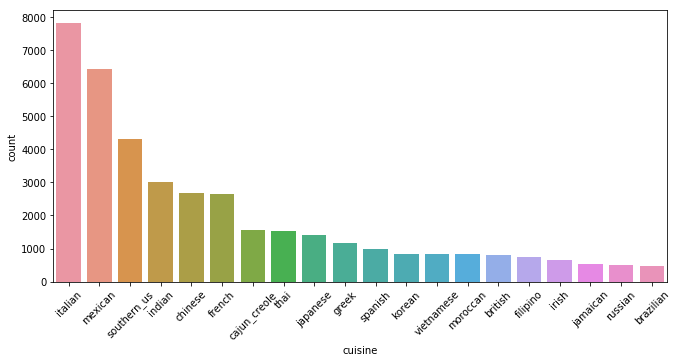

In [8]:
# number of recipes of each class
plt.figure(figsize=(11,5))
sns.countplot("cuisine", data=train, order=train["cuisine"].value_counts().index)
plt.xticks(rotation=45)

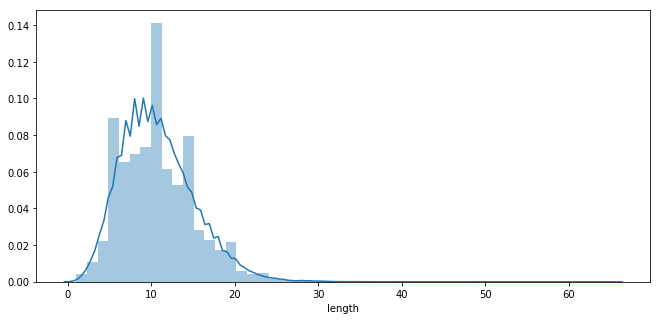

In [9]:
# distribution of length of recipes
plt.figure(figsize=(11,5))
sns.distplot(train["length"])

In [10]:
# dictionary with numbers that represent each ingredient
name2idx = {name : idx+1 for idx, name in enumerate(ingredients_list)}
num_of_ings = len(ingredients_list)

for df in [train, test]:
    print(df["length"].max()) # max number of ingredients is 65

65
50


In [11]:
features = train["length"].max()

In [12]:
# converting ingredient name into integer
train["ingredients"] = train["ingredients"].apply(lambda x: [name2idx[i] for i in x])
test["ingredients"] = test["ingredients"].apply(lambda x: [name2idx[i] for i in x])

In [13]:
# lists of ingredients changed to strings
train["ingredients_onehot"] = train["ingredients"].apply(lambda x: " ".join(str(i) for i in x))
test["ingredients_onehot"] = test["ingredients"].apply(lambda x: " ".join(str(i) for i in x))

print(train.shape)
train.head()

(39774, 4)


,cuisine,ingredients,length,ingredients_onehot
id,,,,
10259,greek,"[1, 2, 3, 4, 5, 6, 7, 8, 9]",9,1 2 3 4 5 6 7 8 9
25693,southern_us,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]",11,10 11 12 13 14 15 16 17 18 19 20
20130,filipino,"[16, 5, 12, 21, 22, 23, 24, 25, 26, 27, 28, 29]",12,16 5 12 21 22 23 24 25 26 27 28 29
22213,indian,"[30, 20, 31, 12]",4,30 20 31 12
13162,indian,"[32, 33, 34, 35, 36, 37, 19, 28, 12, 38, 30, 3...",20,32 33 34 35 36 37 19 28 12 38 30 39 40 41 42 4...


In [14]:
# for further analysis only recipes with length higher than 4 ingredients
# and lower than 20 are considered, set reduced by around 10%
max_ = 20
min_ = 4
train.loc[(train["length"]<max_) & (train["length"]>min_), "ingredients_onehot"].shape

(36374,)

In [15]:
# data represented as one hot table using Count Vectorizer 
from sklearn.feature_extraction.text import CountVectorizer

# ingredients with frequency lower than 5 will be removed
# ingredients which exist in over 90% recipes will be removed
vectorizer = CountVectorizer(binary=True, min_df=5, max_df=0.9, max_features=len(ingredients_list))
vect = vectorizer.fit(train["ingredients_onehot"])
X_train_onehot = vectorizer.transform(train.loc[(train["length"]< max_) & (train["length"]>min_),"ingredients_onehot"])
X_test_onehot = vectorizer.transform(test["ingredients_onehot"])

In [16]:
print(X_train_onehot.shape)
print(X_test_onehot.shape)

(36374, 3328)
(9944, 3328)


In [17]:
# tragets as one hot table
from keras.utils import to_categorical

cuisine2idx = {c:i for i, c in enumerate(train.groupby("cuisine").max().index)}
y = to_categorical(train.loc[(train["length"]<max_) & (train["length"]>min_), "cuisine"].map(cuisine2idx).values)
y.shape

Using TensorFlow backend.


(36374, 20)

## 3. Deep Learning model, Neural Network

In [18]:
# Neural Network model
# fully connected neural network will be used
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, Flatten
from keras.models import Sequential

def fcnn():
    model = Sequential()
    model.add(Dense(2048, activation="relu", input_dim=len(vectorizer.get_feature_names())))
    model.add(Dropout(0.8))
    model.add(Dense(20, activation="softmax"))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [19]:
# Model summary
model = fcnn()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              6817792   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                40980     
Total params: 6,858,772
Trainable params: 6,858,772
Non-trainable params: 0
_________________________________________________________________


In [20]:
# training model with preapred data set
model.fit(X_train_onehot, y, epochs=6, batch_size=16, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/6
36374/36374 [==============================] - 148s 4ms/step - loss: 1.0695 - acc: 0.6956
Epoch 2/6
36374/36374 [==============================] - 147s 4ms/step - loss: 0.7242 - acc: 0.7863
Epoch 3/6
36374/36374 [==============================] - 148s 4ms/step - loss: 0.6108 - acc: 0.8161
Epoch 4/6
36374/36374 [==============================] - 147s 4ms/step - loss: 0.5281 - acc: 0.8410
Epoch 5/6
36374/36374 [==============================] - 148s 4ms/step - loss: 0.4565 - acc: 0.8612
Epoch 6/6
36374/36374 [==============================] - 150s 4ms/step - loss: 0.4085 - acc: 0.8736


In [21]:
# predict classes for test set
idx2cuisine = {i:c for c, i in cuisine2idx.items()}

pred = model.predict_classes(X_test_onehot)
print(pred.shape)

(9944,)


In [22]:
# predicted integers translated to cuisine label
preds = np.array([idx2cuisine[i] for i in pred])
preds

array(['irish', 'southern_us', 'italian', ..., 'italian', 'southern_us',
       'mexican'], dtype='<U12')

## 4. File submission and kaggle score

In [24]:
pd.DataFrame({"id" : test.index,
             "cuisine" : preds}).set_index("id").to_csv("FCNN_n2048_1lay_do.8_onehot_below20_over4_words5_alldata_v2.csv")

# Kaggle score 0.79977